- #  ARIMA vs SARIMA 

## IMPORT THE NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format

- ## IMPORT THE DATASET

In [2]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


- ## CHECK FOR MISSING VALUES AND BASIC INFO

In [3]:
data.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


- ### NO MISSING VALUES
- ### CONVERT THE MONTH COLUMN TO DATETIME DATATYPE AND ASSIGN IT AS INDEX 

In [5]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- ## FUNCTIONS FOR TIMESERIES ANALYSIS

In [6]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

- ## DATA 

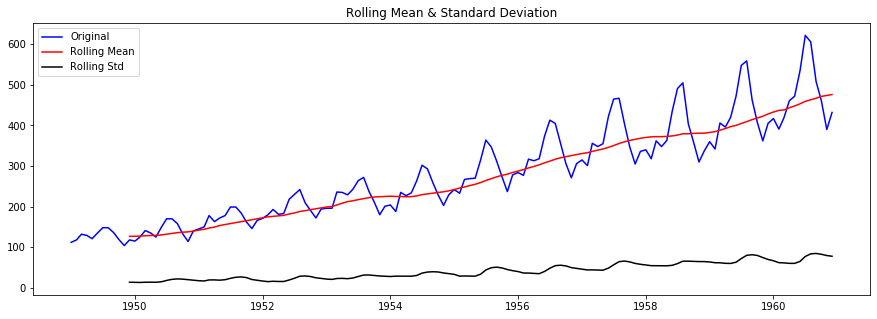

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [8]:
test_stationarity(data['Passengers'])

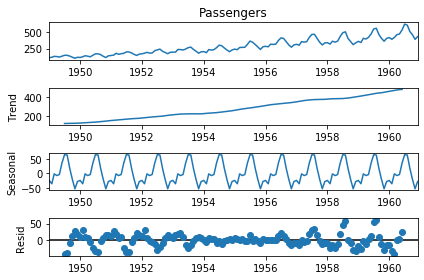

In [9]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12).plot()
plt.show()

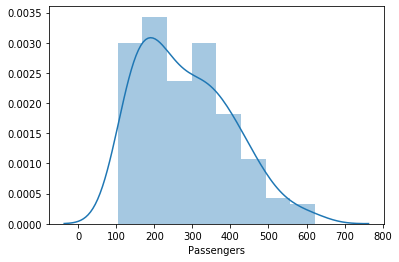

In [10]:
sns.distplot(data['Passengers'])

- ### DATA IS NOT STATIONARY AS THE TEST STATISTIC VALUE IS MORE THAN ANY OF THE CRITICAL VALUE
- ### ALSO THE P-Value IS NOT LESS THAN 0.05
- ### DATA HAS AN INCREASING TREND
- ### DATA IS ALSO SEASONAL WITH A PATTERN OF 1 YEAR

- ## LOG DATA

In [11]:
log_data = np.log(data)
log_data.head()

,Passengers
Date,
1949-01-01,4.72
1949-02-01,4.77
1949-03-01,4.88
1949-04-01,4.86
1949-05-01,4.80


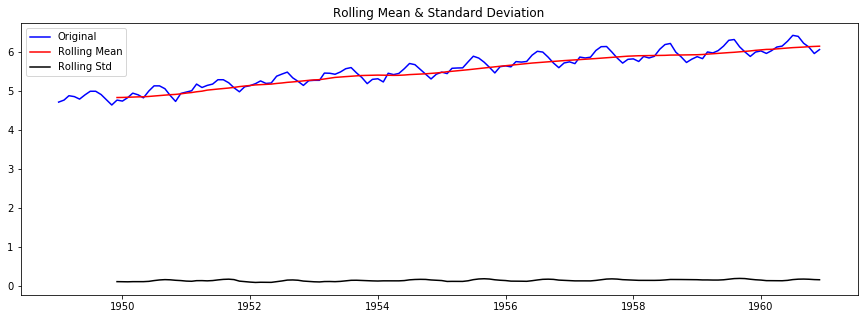

Results of Dickey-Fuller Test:
Test Statistic                 -1.72
p-value                         0.42
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [12]:
test_stationarity(log_data['Passengers'])

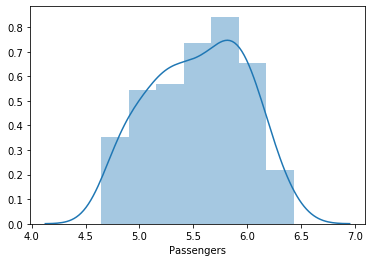

In [13]:
sns.distplot(log_data['Passengers'])

- ### LOG DATA ALSO HAS THE SAME ATTRIBUTES AS THAT OF DATA
- ### ONLY THE DATA DISTRIBUTION IS SLIGHTLY BETTER THAN PREVIOUS

## DIFFERENCING

- ## 1] DATA

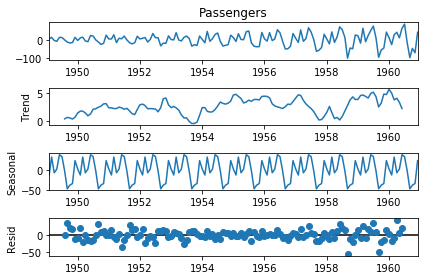

In [14]:
data_diff = data['Passengers'].diff()
data_diff = data_diff.dropna()
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

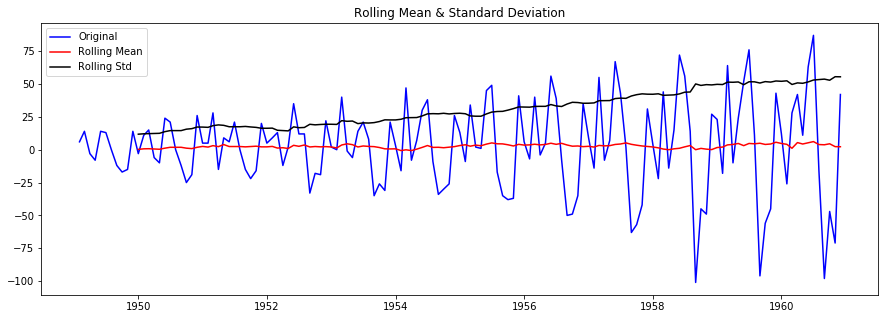

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [15]:
test_stationarity(data_diff)

- ### TREND HAS DIED DOWN AND IS CONSTANT
- ### TEST STATISTIC < CRITICAL VALUE(10%) --> DATA IS 90% SURELY STATIONARY
- ### P-Value = 0.05
- ### ROLLING IS ALSO CONSTANT
- ### HENCE DATA IS STATIONARY
- ### HOWEVER SEASONALITY IS STILL PRESENT

- ## 2] LOG DATA

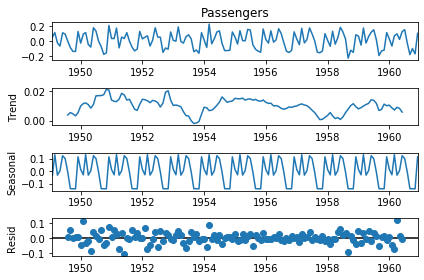

In [16]:
log_data_diff = log_data['Passengers'].diff()
log_data_diff = log_data_diff.dropna()
dec = sm.tsa.seasonal_decompose(log_data_diff,period = 12)
dec.plot()
plt.show()

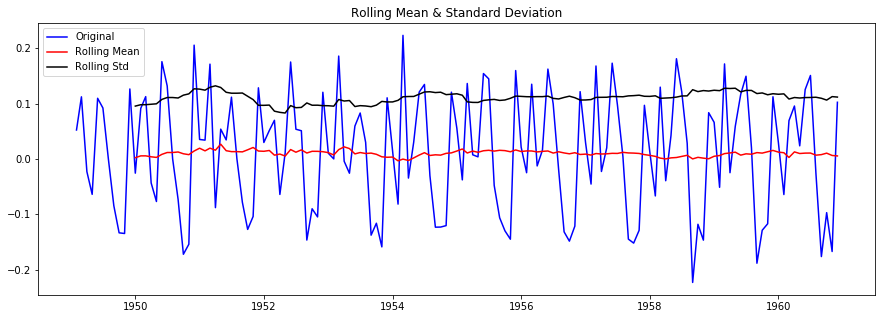

Results of Dickey-Fuller Test:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [17]:
test_stationarity(log_data_diff)

- ### TREND HAS DIED DOWN AND IS CONSTANT
- ### TEST STATISTIC < CRITICAL VALUE(10%) --> DATA IS 90% SURELY STATIONARY
- ### P-Value = 0.05
- ### ROLLING IS ALSO CONSTANT
- ### HENCE DATA IS STATIONARY
- ### HOWEVER SEASONALITY IS STILL PRESENT

- ## FROM THE ABOVE TESTS, WE CAN CHOOSE ANY OF THE DATA ABOVE FOR SELECTING THE ORDER OF ARIMA

# ARIMA [p,d,q]

- ## DATA 

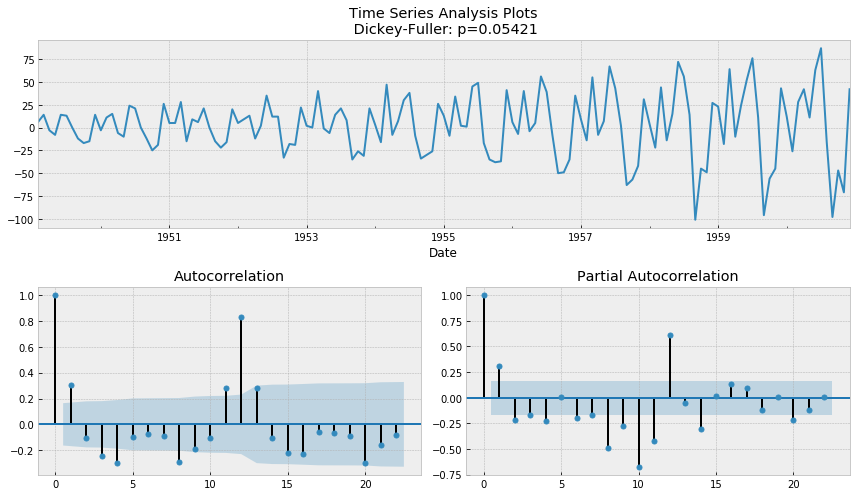

In [18]:
tsplot(data_diff)

- ### ARIMA MODEL ORDER [p,d,q]
- ### p = PARTIAL AUTOCORRELATION PLOT = LAG VALUE AT WHICH THE LINE TOUCHES THE CONFIDENCE INTERVAL FIRST
- ### d = DIFFERENCING ORDER
- ### q = AUTOCORRELATION PLOT =  LAG VALUE AT WHICH THE LINE TOUCHES THE CONFIDENCE INTERVAL FIRST

- ### FOR OUR MODEL :- 
- ### p = [1-2]
- ### d = 1
- ### q = [1-2]
- ### SELECT THE ORDER OF ARIMA MODEL WITH THE LOWEST AIC VALUE

In [19]:
model = ARIMA(data['Passengers'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

E:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.715
Date:                Wed, 17 Jun 2020   AIC                           1344.043
Time:                        02:02:14   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.Passengers  

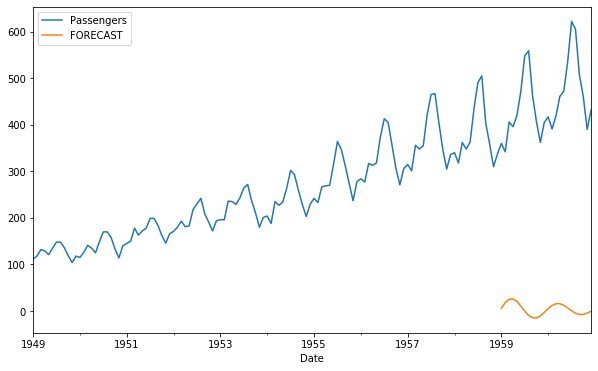

In [20]:
data['FORECAST'] = model_fit.predict(start = 120,end = 144,dynamic = True)
data[['Passengers','FORECAST']].plot(figsize = (10,6))

In [21]:
exp = [data.iloc[i,0] for i in range(120,len(data))]
pred = [data.iloc[i,1] for i in range(120,len(data))]
data = data.drop(columns = 'FORECAST')
print(mean_absolute_error(exp,pred))

448.26886407061846


- ### THE PREDICTION PLOTS ARE NOT GOOD AT ALL 
- ### THE MEAN ABSOLUTE ERROR VALUE IS ALSO HIGH
- ### THIS IS BECAUSE OF THE ISSUE OF SEASONALITY
- ### HENCE WE REJECT ARIMA MODEL AND MOVE ONTO SARIMA WHICH HANDLES SEASONALITY

# SARIMA [(p,d,q)x(P,D,Q,s)]

- ## DATA

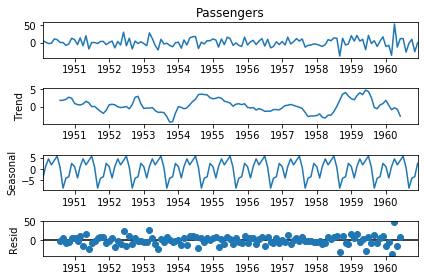

In [22]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

- ### SEASONAL DIFFERENCE WITH A SEASONAL PERIOD(s) OF 12
- ### SINCE OUR DATA IS MONTHLY DATA AND FROM THE PLOTS,WE OBSERVE THAT A YEARLY PATTERN IS PRESENT
- ### WE USE THIS OPERATION ON THE PREVIOUSLY DIFFERENCED DATA SO THAT WE DO  NOT HAVE TO DEAL WITH TREND & STATIONARITY AGAIN

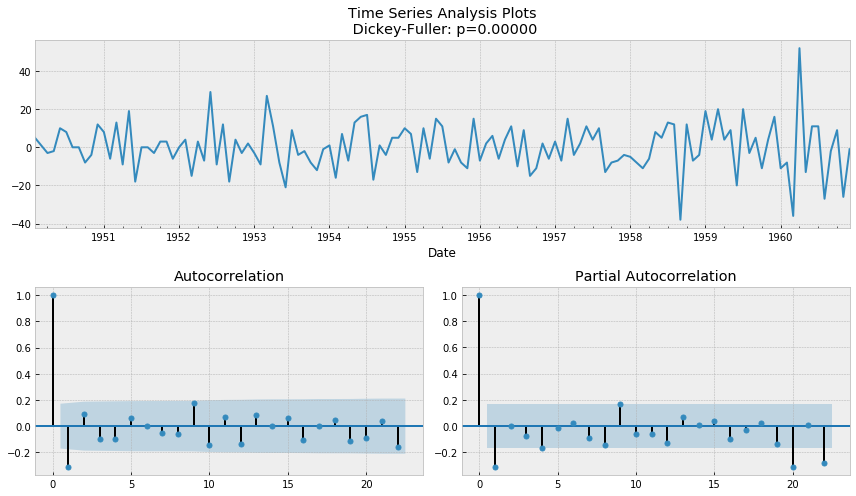

In [23]:
tsplot(data_diff_seas)

- ### SARIMA MODEL ORDER [(p,d,q)x(P,D,Q,s)]
- ### (p,d,q) = THIS ORDER IS INHERITED FROM OUR ABOVE ARIMA MODEL
- ### (P,D,Q,s) = THIS IS ORDER IS SELECTED USING THE SAME TECHNIQUE USED FOR ARIMA
- ### s = SEASONAL ORDER = ONLY ADDITIONAL PARAMETER 
- ### WE AGAIN SELECT THE MODEL WITH LEAST AIC SCORE

In [24]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (1,1,2,12))
results = model.fit()
print(results.summary())

E:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\ANACONDA\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -498.994
Date:                            Wed, 17 Jun 2020   AIC                           1013.988
Time:                                    02:02:45   BIC                           1036.989
Sample:                                01-01-1949   HQIC                          1023.334
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6124      0.406      1.510      0.131      -0.183       1.407
ar.L2          0.2191      0.318   

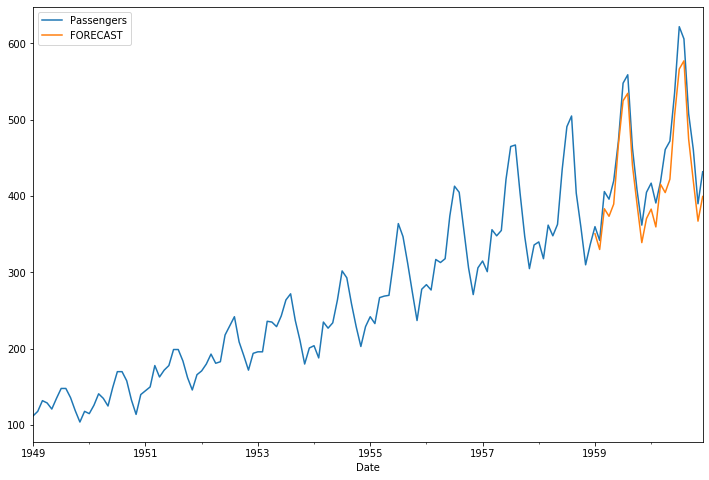

In [25]:
data['FORECAST'] = results.predict(start = 120,end = 144,dynamic = True)
data[['Passengers','FORECAST']].plot(figsize = (12,8))

In [26]:
exp = [data.iloc[i,0] for i in range(120,len(data))]
pred = [data.iloc[i,1] for i in range(120,len(data))]
data = data.drop(columns = 'FORECAST')
print(mean_absolute_error(exp,pred))

27.720655347019527


- ### PREDICTED PLOTS ARE GREAT 
- ### ERROR HAS ALSO REDUCED ALOT
- ### HENCE WE ACCEPT THIS MODEL AND FORECAST FOR 2 MORE YEARS

# FORECASTING

- ## ADD DATES TO OUR DATAFRAME FOR OUR FORECASTING PURPOSE

In [27]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(months = x)for x in range(0,25)]
df = pd.DataFrame(index = future_dates[1:],columns = data.columns)

- ## FINAL PLOT

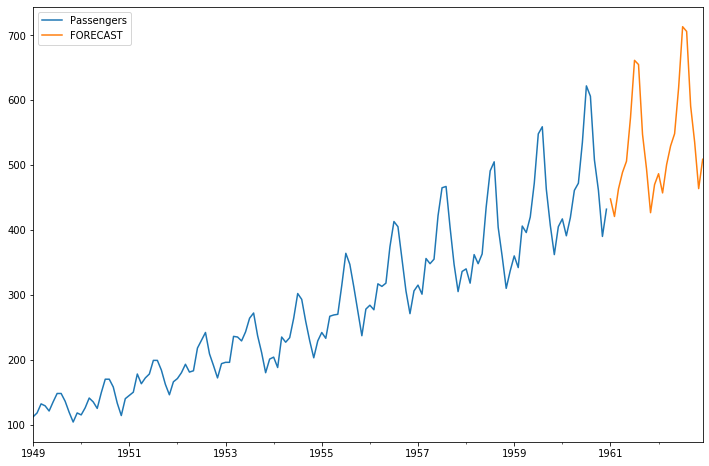

In [28]:
forecast = pd.concat([data,df])
forecast['FORECAST'] = results.predict(start = 144,end = 168,dynamic = True)
forecast[['Passengers','FORECAST']].plot(figsize = (12,8))

# THANK YOU